In [1]:
import sys # Python ≥3.5 is required
assert sys.version_info >= (3, 5)
import os
import sklearn # Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
assert tf.__version__ >= "2.0" # Tensorflow 
import PIL
import PIL.Image
import pathlib 
from tensorflow.keras.preprocessing import image_dataset_from_directory

# for loading files on google drive 
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Classroom/CMSC352 Fall 2020/Chess"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Bishop	King  Knight  Pawn  Queen  Rook


Main Reference: 
1.   [Tensorflow Loading Image](https://www.tensorflow.org/tutorials/load_data/images) 
2.   https://www.tensorflow.org/tutorials/images/transfer_learning


# Data Preparation and Image Augmentation
Deleted by hand 4 files of imcompatible file types from the total 556 files. 






In [2]:
# loading image from source 
image_dir = "/content/drive/My Drive/Classroom/CMSC352 Fall 2020/Chess"
data_dir = pathlib.Path(image_dir)
image_count = len(list(data_dir.glob('*/*')))
print(image_count) # check that path is loaded successfully 

552


Now split the dataset: 70% for training, 10% validation, and 20% testing.

In [3]:
## parameters for creation of image batches dataset
batch_size = 10
img_height = 180
img_width = 180
IMG_SIZE = (img_height, img_width)

# Create dataset 
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# break datasets into validation (10%), test(20%) and training dataset(70%) 
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset       = validation_dataset.take(val_batches*2 // 3)
validation_dataset = validation_dataset.skip(val_batches*2 // 3)

class_names = train_dataset.class_names


## Uncomment the following lines to check whether creating and splitting the dataset is successfull
# print(class_names)
# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

# Use buffered prefetching to load images from disk without having I/O become blocking. 
# For detail see the tensorflow data performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 551 files belonging to 6 classes.
Using 386 files for training.
Found 551 files belonging to 6 classes.
Using 165 files for validation.


Since we have only a small dataset, let's  create some realistic variation and enlarge our training dataset with data augumentation. This will also prevent the model from overfitting. We flip the images horizontally as many of them are flipped in the dataset. Apply random rotation since not all pictures are taken perfectly aligned. Apply random Width to compensate for the possible distortion caused by resacaling to fit the modle input size. 

In [4]:
# Note: These layers are active only during training, when you call `model.fit`. 
# They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.
data_augmentation = tf.keras.Sequential([
  # tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  # tf.keras.layers.experimental.preprocessing.RandomCrop(height=img_height, width=img_width),
  # tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  # tf.keras.layers.experimental.preprocessing.RandomWidth(factor=(.1, .4)),
  # # tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(.1, .2), width_factor=(.1, .2)),
  # tf.keras.layers.experimental.preprocessing.RandomContrast(factor = 0.2),
  # # tf.keras.layers.experimental.preprocessing.RandomTranslation(
  #   height_factor = 0.2 , width_factor=0.2)
])

# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

# Baseline Model
Resuse the pre-trained ResNet50 ImageNet model, which is also used for similar image classification tasks, to extract low level features. Add a classifier on top of it and train the top-level classifier to adapt the model to our specific task of classifying chess pieces. 
 


In [5]:
tf.keras.backend.clear_session()

# Use the same preprocessing format as `resnet50`. 
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# Create the base model from the pre-trained model ResNet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# This feature extractor converts each `180x180x3` image into a `6x6x2048` block 
# of features. Let's see what it does to an example batch of images:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# Freeze the convolutional base of the pre-trained model so it remembers the how 
# to extract thn low level features
base_model.trainable = False

# Let's take a look at the base model architecture
# base_model.summary()

(10, 6, 6, 2048)


**Add a classification Head and Compile the model** 

In [6]:
# To generate predictions from the block of features, average over the spatial 6x6 spatial
# locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to 
# a single 2048-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Apply a `tf.keras.layers.Dense` layer to convert these features into predictions
nlabels = 6 # we have six class of chess pieces
# use softmax for multiclass classification
prediction_layer = tf.keras.layers.Dense(nlabels, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

# Build a model by chaining together the data augmentation, rescaling, base_model 
# and feature extractor layers using the Keras Functional API
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Since there are multiple classes and they are all mutually exclusive, use 
# SparseCategoricalCrossentropy as our loss function 
base_learning_rate = 0.0001 # chosse a small learning rate < e-4

# Use Adam for large network and to make training efficient
# this will change the learning rate based on momentum
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
len(model.trainable_variables)

(10, 2048)
(10, 6)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      multiple                  0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 180, 180, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 180, 180, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 6, 6, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None,

2

Now we train the top classifier while freezing the convolutional base. 




In [7]:
initial_epochs = 34
## uncomment for quick preview of performance
# loss0, accuracy0 = model.evaluate(validation_dataset)
# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

#  enable early stopping once the accuracy on validation dataset starts decreasing 3 times in a row 
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    # callbacks=[callback]
                    )

Epoch 1/34
39/39 [==============================] - 6s 148ms/step - loss: 1.7645 - accuracy: 0.2435 - val_loss: 1.7957 - val_accuracy: 0.2000
Epoch 2/34
39/39 [==============================] - 5s 120ms/step - loss: 1.7200 - accuracy: 0.3031 - val_loss: 1.7353 - val_accuracy: 0.3091
Epoch 3/34
39/39 [==============================] - 5s 118ms/step - loss: 1.6668 - accuracy: 0.3808 - val_loss: 1.7085 - val_accuracy: 0.3273
Epoch 4/34
39/39 [==============================] - 5s 117ms/step - loss: 1.6248 - accuracy: 0.4378 - val_loss: 1.7034 - val_accuracy: 0.3455
Epoch 5/34
39/39 [==============================] - 5s 116ms/step - loss: 1.5821 - accuracy: 0.5311 - val_loss: 1.6629 - val_accuracy: 0.3455
Epoch 6/34
39/39 [==============================] - 5s 120ms/step - loss: 1.5488 - accuracy: 0.5492 - val_loss: 1.6324 - val_accuracy: 0.4364
Epoch 7/34
39/39 [==============================] - 5s 119ms/step - loss: 1.5108 - accuracy: 0.6062 - val_loss: 1.5632 - val_accuracy: 0.4909
Epoch 

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the ImageNet ResNet50 base model as a fixed feature extractor.

11/11 [==============================] - 1s 111ms/step - loss: 1.3914 - accuracy: 0.7091
Test accuracy : 0.7090908885002136


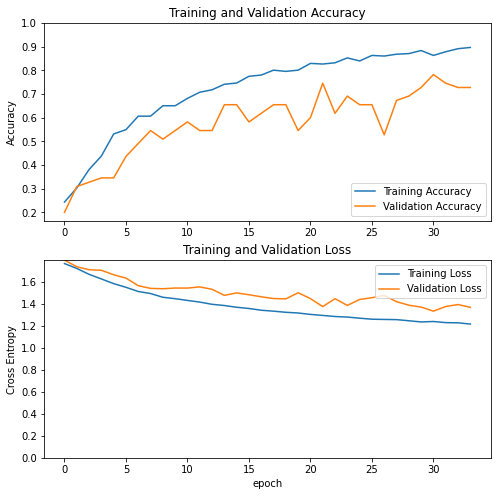

In [8]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(max(val_loss),max(loss))])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### Un-freeze the top layers of the model


In [9]:
#Unfreeze the top layers of the model to train them 
#This will make the generic ResNet50 become more specific to the chess dataset
base_model.trainable = True

# Let's take a look to see how many layers are in the base model => 175
# print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards. Freeze all the layers before the `fine_tune_at` layer
fine_tune_at = 100 # find this by trail and error
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# The model is now large so it's important to use a lower learning rate to prevent overfitting
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])
# model.summary()
#len(model.trainable_variables)



### Continue training the model

In [10]:
# enable early stopping 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

fine_tune_epochs = 8
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[callback]
                         )

Epoch 34/42
39/39 [==============================] - 6s 156ms/step - loss: 1.1881 - accuracy: 0.8886 - val_loss: 1.3105 - val_accuracy: 0.7273
Epoch 35/42
39/39 [==============================] - 5s 134ms/step - loss: 1.1099 - accuracy: 0.9430 - val_loss: 1.2323 - val_accuracy: 0.8000
Epoch 36/42
39/39 [==============================] - 5s 132ms/step - loss: 1.0838 - accuracy: 0.9611 - val_loss: 1.3183 - val_accuracy: 0.7091
Epoch 37/42
39/39 [==============================] - 5s 134ms/step - loss: 1.0799 - accuracy: 0.9663 - val_loss: 1.2349 - val_accuracy: 0.8364
Epoch 38/42
39/39 [==============================] - 5s 134ms/step - loss: 1.0633 - accuracy: 0.9845 - val_loss: 1.2654 - val_accuracy: 0.8000
Epoch 39/42
39/39 [==============================] - 5s 130ms/step - loss: 1.0589 - accuracy: 0.9870 - val_loss: 1.2406 - val_accuracy: 0.8182
Epoch 40/42
39/39 [==============================] - 5s 136ms/step - loss: 1.0543 - accuracy: 0.9896 - val_loss: 1.2514 - val_accuracy: 0.8000

In [11]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

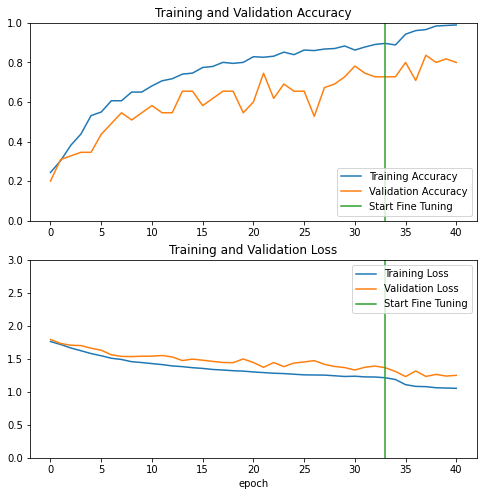

In [12]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Let's veiw the confusion matrix and figure out what are the most misclassified labels. 

In [13]:
labels = []
predictions = []

for i in range(tf.data.experimental.cardinality(test_dataset)):
  image_batch, label_batch = test_dataset.as_numpy_iterator().next()
  labels += list(label_batch)
  predictions += list(np.argmax( tf.nn.sigmoid(model.predict_on_batch(image_batch)).numpy(), axis = 1 ) )

conf_mat = tf.math.confusion_matrix(labels, predictions, num_classes=6)
print(" Confusion Matrix", conf_mat)
print( "The most misclassified to is the", class_names[1] ) # the 2nd column
print( "The class that is the most often misclassified as King is", class_names[4], "\n\n\n\n" )#the 5th row

# Test Accuracy 
TP = tf.linalg.trace( conf_mat ).numpy()
ALL = tf.math.reduce_sum( conf_mat).numpy()
print("Test Accuracy", TP / ALL, "\n\n\n\n")

# F1 Score 
import sklearn.metrics
print( "F1 Score",  sklearn.metrics.f1_score(labels, predictions, average = None))
print( "Labels :", class_names, "\n\n\n\n")

# import tensorflow_addons as tfa
# m = tfa.metrics.F1Score(num_classes=6)
# m.update_state(labels, predictions)
# print("F1 Score", m.result().numpy())

 Confusion Matrix tf.Tensor(
[[18  0  0  1  0  0]
 [ 1  6  0  0  4  0]
 [ 0  0 19  0  0  0]
 [ 2  2  0 21  2  0]
 [ 1  1  0  0 16  2]
 [ 0  0  0  0  0 14]], shape=(6, 6), dtype=int32)
The most misclassified to is the King
The class that is the most often misclassified as King is Queen 




Test Accuracy 0.8545454545454545 




F1 Score [0.87804878 0.6        1.         0.85714286 0.76190476 0.93333333]
Labels : ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook'] 






The low F1 score of King confirms our result from the confusion matrix -- other classes are often classified as King and King is often misclassfied. The high F1 score of Knight tell us that it is the most distinguishable from other chess peices. 



Labels:
 [1 3 3 5 2 5 2 1 4 4]
Predictions:
 [4 0 3 5 2 5 2 4 4 4]


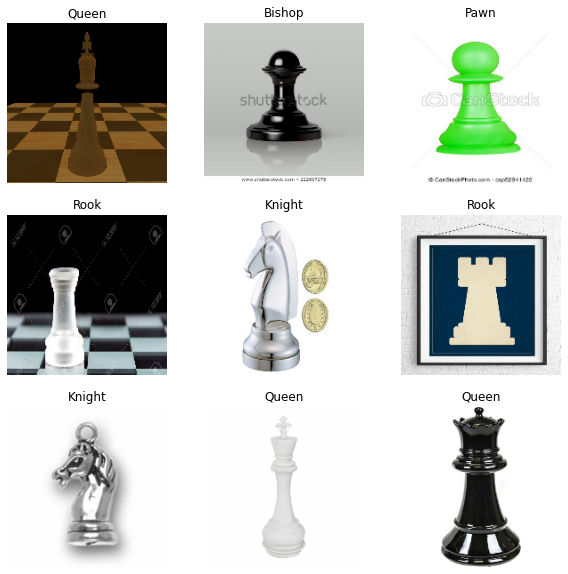

In [14]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)

# find the most likely prediction
predictions = np.argmax( predictions.numpy(), axis =1)

print('Labels:\n', label_batch)
print('Predictions:\n', predictions)

# for i in range(9):    
#   print('Labels:', class_names[label_batch[i]])
#   print('Predictions:', class_names[predictions[i]])

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Conclusion 
By simply attaching one activation layer, the pretrained model come in with around 60% accuracy . The newly added layer give a boost of around 10-20% accuracy, depending on other parameter.

For the classification layer, I tried both GlobalAveragePoolingLayer as well as using a stack of Dense and 1 DropOut layer, and it turned out that the GlobalAveragePoolingLayer worked better for this particular task.

Data augmentation has the potential to
1) add diversity to avoid overfitting and 2) compensate for our small dataset. However, the data augumentation didn't increased the accuracy much. The training without data augmentation could acheive the same result or better than with it. Flipping horizontally and small rotation lead to small increase in training performance. 

However, there are simply too many parameters (number of layers to freeze, data augumentation, number of layers of the top model, structure of the classificaiton layer,training epoch and more) involved in the training process, one cannot simply pin down which parameter lead to good classification. 



